# Explore the characteristics of the data that we are using as the base data sets

This notebook explores the characteristics of the base data sets that we are using to generate data using RealCause (or Credence). 

In [1]:
# Import libraries 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

## ACIC 2019 (Low dimensional datasets)

In [4]:
# Read the data from the file
data = pd.read_csv('../base_datasets/low_dim_1.csv')
print(data.head())

   Y  A  V1  V2  V3  V4  V5    V6  V7    V8  V9  V10
0  0  0  18   4  15   1   0   0.0   0   0.0   0  0.0
1  0  0  15   1  14   1   0   0.0   0   0.0   0  0.0
2  1  0  52   5  16   4   1  37.0   1   3.0   0  0.0
3  1  1  46   3  21   4   0   0.0   1  15.0   0  0.0
4  0  0  42   3  23   2   0   0.0   0   0.0   0  0.0


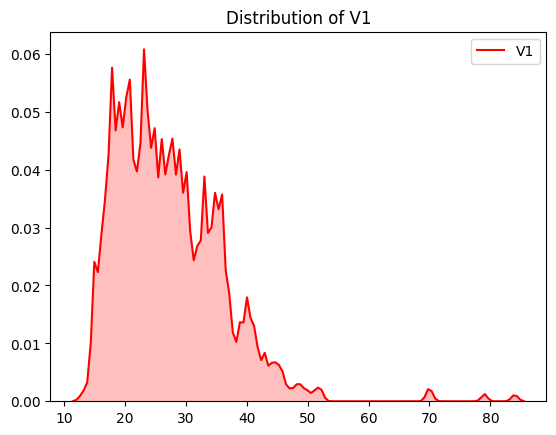

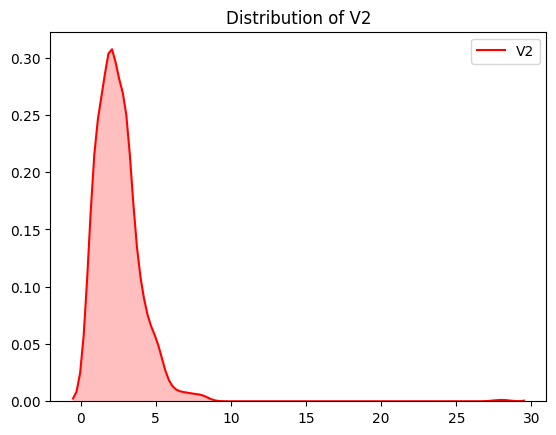

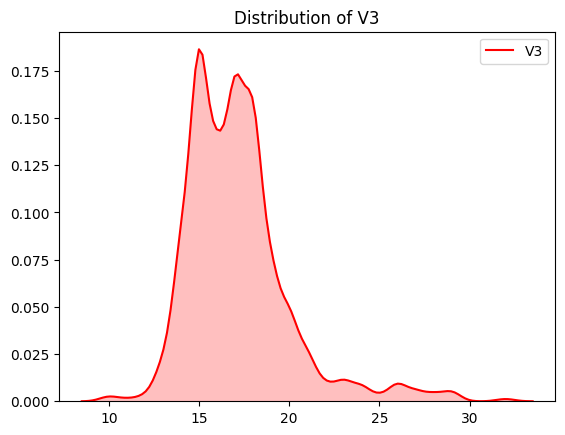

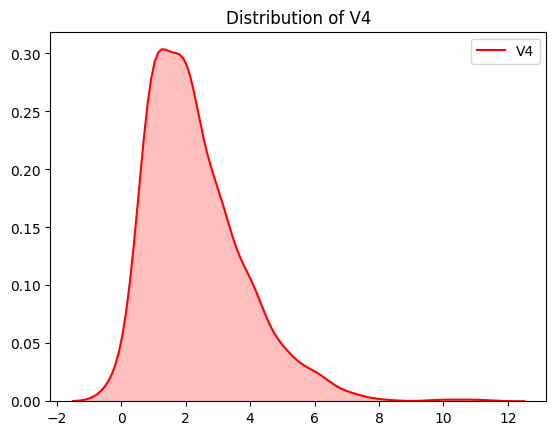

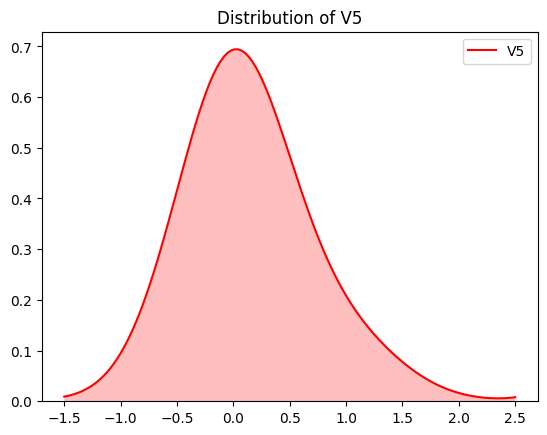

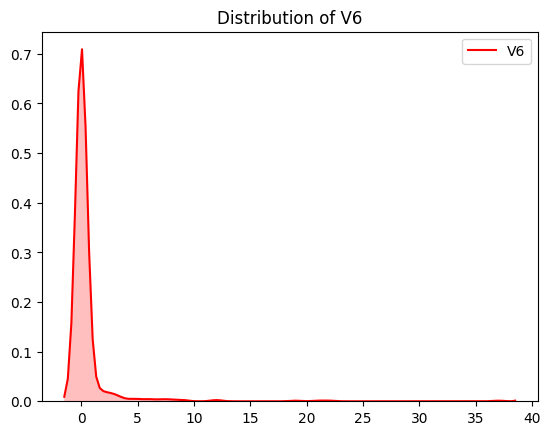

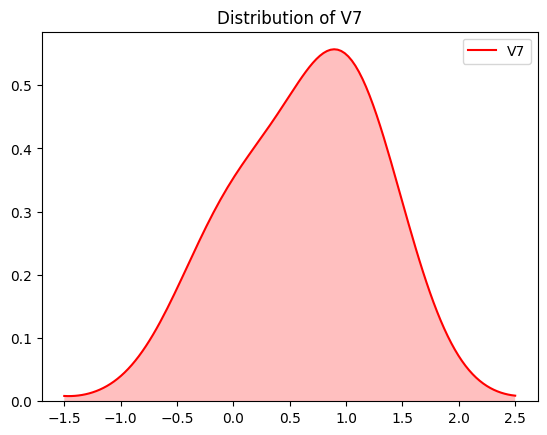

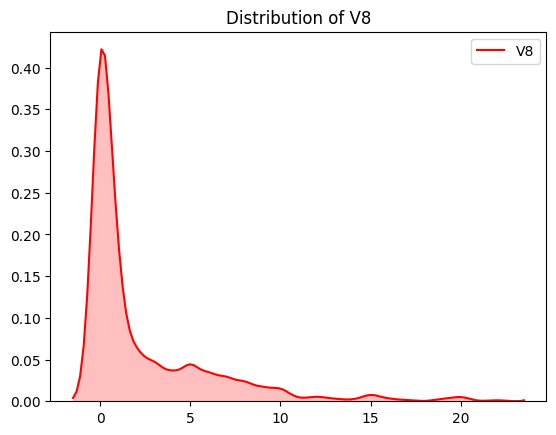

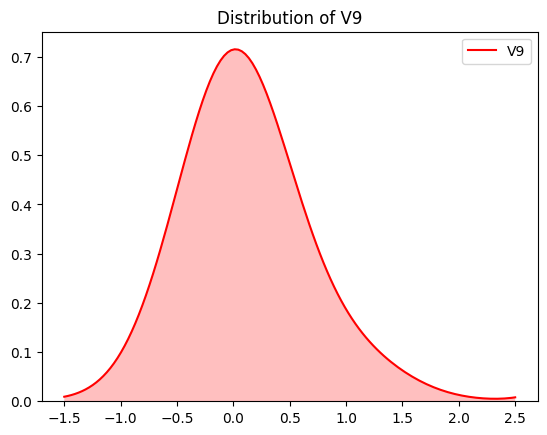

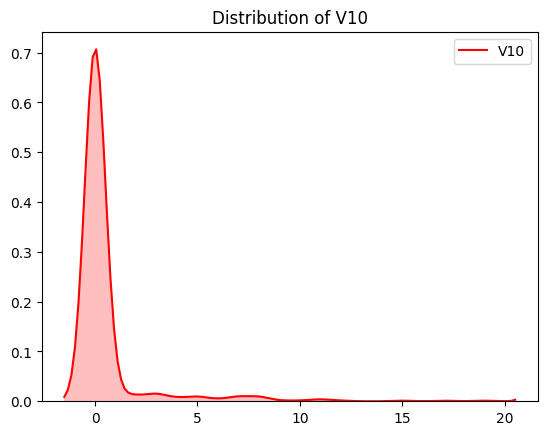

In [5]:
# Create plots of the distribution of the covariates; the covariates are columns V1 to V10
for i in range(1, 11):
    sns.kdeplot(data=data['V'+str(i)], shade=True, color='r', bw=0.5)
    plt.title('Distribution of V'+str(i))
    plt.show()

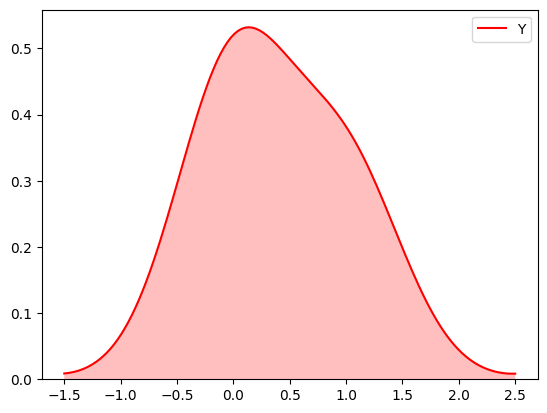

In [6]:
# Create a plot of the distribution of the target variable
sns.kdeplot(data=data['Y'], shade=True, color='r', bw=0.5)

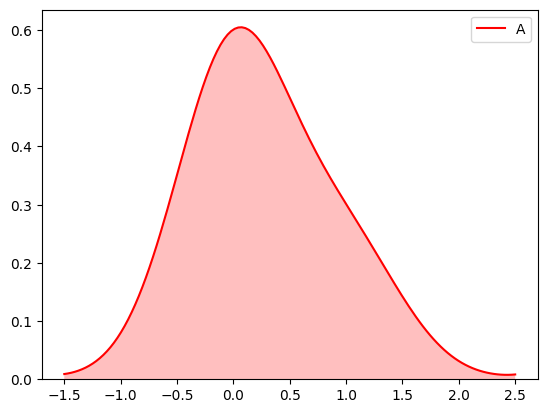

In [7]:
# Create a plot of the treatment variable "A"
sns.kdeplot(data=data['A'], shade=True, color='r', bw=0.5)

In [ ]:
# Code to compute the positivity/overlap for this particular dataset
# Source: https://blog.dataiku.com/evaluating-positivity-methods-in-causal-inference

import flaml
import numpy as np
import sklearn

class IBMForest:

def __init__(self, X, t, rf_type='flaml_default', separate_treat_control=True, max_minutes=2, homogeneity_threshold=0):
    super().__init__()
    if rf_type == 'sklearn':
        self.model = sklearn.ensemble.RandomForestClassifier()
    elif rf_type == 'flaml_default' or rf_type == 'flaml':
        self.model = flaml.default.RandomForestClassifier()
    elif rf_type == 'flaml_tuned':
        self.model, _ = train_automl_pipeline(X, t, max_minutes=max_minutes, estimator_list=['rf'])
    else:
        raise ValueError('rf_type must be flaml or sklearn')
    self.X = X
    self.t = t
    self.separate_treat_control = separate_treat_control
    self.homogeneity_threshold = homogeneity_threshold
    self.min_tree_threshold = 0.5
    self.model.fit(X, t)

def predict_propensity(self, X):
    """Predict propensity scores for each observation in X."""
    return self.model.predict_proba(X)[:, 1]

def predict_positivity_violation(self, X, separate_treat_control=None, min_tree_threshold=None,
homogeneity_threshold=None):
    """
    Predict positivity violations for each observation in X. Implements the rule described in Section 3.2.1 of this
    paper: https://arxiv.org/abs/1907.08127

    :param X: Data to predict positivity violations for
    :param separate_treat_control: If False, then the violations are aggregated as described in the paper ("fraction
    of times it was counted as a violation"); if True, the positivity violations are computed separately for
    treated and control
    :param min_tree_threshold: Minimum proportion of trees that must predict a violation for the observation to be
    considered a violation
    :param homogeneity_threshold: Minimum proportion of observations in a leaf that must be of the same treatment
    status for the leaf to be considered homogeneous
    :return: A boolean array indicating whether each observation in X violates positivity
    """

    if separate_treat_control is None:
        separate_treat_control = self.separate_treat_control
    if min_tree_threshold is None:
        min_tree_threshold = self.min_tree_threshold
    if homogeneity_threshold is None:
        homogeneity_threshold = self.homogeneity_threshold

    print('min_tree_threshold', min_tree_threshold)

    # Get whether each tree in the forest predicts a violation

    tree_control_violations = []
    tree_treatment_violations = []
    tree_either_violations = []
    for i, tree in enumerate(self.model.estimators_):
        propensities = tree.predict_proba(X)[:, 1]
        control_violations = propensities <= homogeneity_threshold
        treatment_violations = propensities >= 1 - homogeneity_threshold
        either_violations = control_violations | treatment_violations

        tree_control_violations.append(control_violations)
        tree_treatment_violations.append(treatment_violations)
        tree_either_violations.append(either_violations)

    # Get the fraction of trees that predict a control violation: P(T = 1 | X) = 0
    frac_control_violations = np.array(tree_control_violations).mean(axis=0)

    # Get the fraction of trees that predict a treatment violation: P(T = 1 | X) = 1
    frac_treatment_violations = np.array(tree_treatment_violations).mean(axis=0)

    # Get the fraction of trees that predict a violation
    frac_either_violations = np.array(tree_either_violations).mean(axis=0)

    # For each sample, get the fraction of trees that predict whichever violation is more common:
    # P(T = 1 | X) = 0 or P(T = 1 | X) = 1
    if separate_treat_control:
        frac_violations = np.array([frac_control_violations, frac_treatment_violations]).max(axis=0)
    else:
        frac_violations = frac_either_violations

    # Threshold the fraction of trees that predict a violation
    pred_violations = frac_violations >= min_tree_threshold

    return pred_violations

In [8]:
# Find the probability of Treatment 
print(data['A'].mean())

0.27994011976047906


In [9]:
# Fit a linear regression model to the data to predict the outcome Y given the covariates V1 to V10 and A
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']]
y = data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.20734613748590444


This shows that the relationship is linear. This is one version of the base dataset. We will also construct our own version of a linear and non-linear outcome so that we have access to the counterfactual outcomes. 

In [54]:
# Create a new outcome Y with the following relationship to the existing variables. 
# Y_linear = a*V1 + b*V2*V3 + c*V4 + d*V6 - e*V7 + f*V8*V9 + g*V10 + h*A + noise
# Here a..h are drawn from a normal distribution with mean 0 and standard deviation 1.
# The noise is drawn from a normal distribution with mean 0 and standard deviation 0.1.
# The new outcome Y_linear is added to the data.
np.random.seed(42)

a, b, c, d, e, f, g, h = np.random.normal(0, 1, 8)
noise_f = np.random.normal(0, 1.0, len(data))
data['Y_linear'] = a*data['V1'] + b*data['V2'] - c*data['V3'] + d*data['V4'] + e*data['V6'] - f*data['V7'] + f*data['V8'] - g*data['V9'] + h*data['V10'] + 0.8*data['A'] + noise_f
# If the treatment is heterogenous, then we can add noise to the counterfactual outcome. 
noise_cf = np.random.normal(0, 1.0, len(data))
data['Y_linear_cf'] = a*data['V1'] + b*data['V2'] - c*data['V3'] + d*data['V4'] + e*data['V6'] - f*data['V7'] + f*data['V8'] - g*data['V9'] + h*data['V10'] + 0.8*(1-data['A']) + noise_f   # make it noise_cf for counterfactual outcome

# Fit a linear regression model to the data to predict the outcome Y_linear given the covariates V1 to V10 and A
X = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']]
y = data['Y_linear']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred)) 

1.2326887608623267


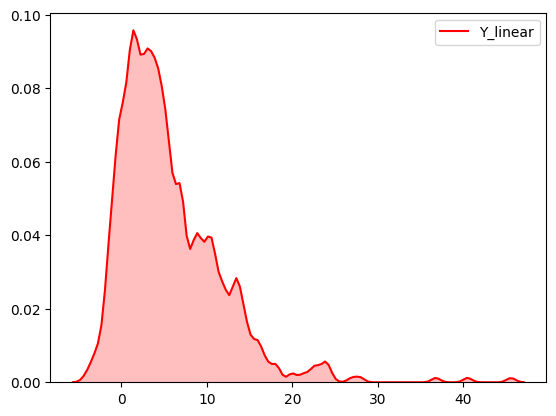

In [55]:
# Create a plot of the new Y_linear variable
sns.kdeplot(data=data['Y_linear'], shade=True, color='r', bw=0.5)

In [56]:
# Create a new dataset with the outcome Y_linear and the covariates V1 to V10 and A
data_linear = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'A', 'Y_linear', 'Y_linear_cf']]
# Rename Y_linear to Y
data_linear = data_linear.rename(columns={'Y_linear': 'Y', 'Y_linear_cf': 'Y_cf'})
# Store the data in a new file
data_linear.to_csv('../base_datasets/low_dim_1_linear.csv', index=False)

In [57]:
# Compute CATE for data_linear dataset: CATE = Y when A = 1, - Y_cf when A = 0
cate_vals = []
for index, row in data_linear.iterrows():
    if row['A'] == 1:
        cate_vals.append(row['Y'] - row['Y_cf'])
    else:
        cate_vals.append(row['Y_cf'] - row['Y'])
print(f'CATE: {np.mean(cate_vals)}')
# Find the variance of the CATE values
print(f'Variance of CATE values: {np.var(cate_vals)}')
print(f'CATE values: {cate_vals}')

CATE: 0.8000000000000002
Variance of CATE values: 2.4054057729371984e-31
CATE values: [0.8, 0.7999999999999999, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.7999999999999998, 0.8000000000000007, 0.8000000000000007, 0.7999999999999998, 0.8000000000000007, 0.7999999999999998, 0.8000000000000007, 0.8000000000000016, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.7999999999999998, 0.8000000000000007, 0.8000000000000003, 0.8000000000000003, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.7999999999999998, 0.7999999999999989, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.8000000000000007, 0.800000

In [27]:
# Create another column Y_polynomial in the data with the following relationship to the existing variables.
# Y_polynomial = a*V1^2 + b*V2*V3 + c*V4 + d*V6^2*V7 + e*V8*V9 + f*V10 - 0.7*A + noise

a, b, c, d, e, f, g = np.random.normal(0, 1, 7)
noise = np.random.normal(0, 0.01, len(data))
data['Y_polynomial'] = a*data['V1']**2 + b*data['V2'] - c*data['V3'] + d*data['V4'] + e*data['V6']*data['V7'] + f*data['V8']*data['V9'] + g*data['V10'] - 0.7*data['A'] + noise
# Create the counterfactual outcome
data['Y_polynomial_cf'] = a*data['V1']**2 + b*data['V2'] - c*data['V3'] + d*data['V4'] + e*data['V6']*data['V7'] + f*data['V8']*data['V9'] + g*data['V10'] - 0.7*(1-data['A']) + noise

# Fit a linear regression model to the data to predict the outcome Y_polynomial given the covariates V1 to V10 and A
X = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']]
y = data['Y_polynomial']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

15560.351775753814


In [28]:
# Create a polynomial regression model to predict the outcome Y_linear given the covariates V1 to V10 and A
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']]
y = data['Y_polynomial']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.13747469046038915


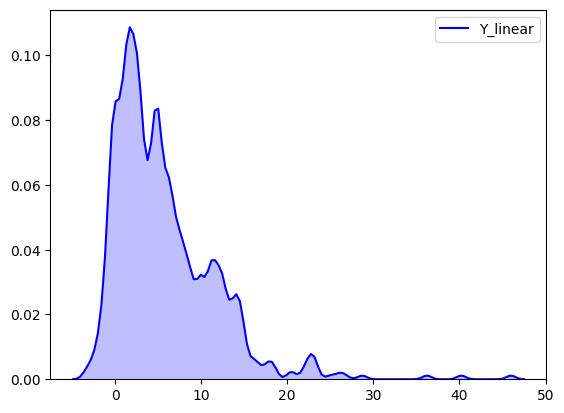

In [29]:
# Create a plot of Y and Y_linear and Y_polynomial
sns.kdeplot(data=data['Y_linear'], shade=True, color='b', bw=0.5)

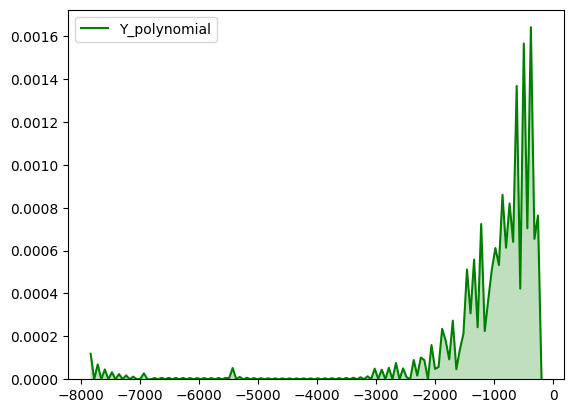

In [30]:

sns.kdeplot(data=data['Y_polynomial'], shade=True, color='g', bw=0.5)

In [31]:
# Create a new dataset with the outcome Y_polynomial and the covariates V1 to V10 and A
data_polynomial = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'A', 'Y_polynomial', 'Y_polynomial_cf']]
# Rename Y_polynomial to Y and Y_polynomial_cf to Y_cf
data_polynomial = data_polynomial.rename(columns={'Y_polynomial': 'Y', 'Y_polynomial_cf': 'Y_cf'})
# Store the data in a new file
data_polynomial.to_csv('../base_datasets/low_dim_1_polynomial.csv', index=False)

In [32]:
# Compute CATE for data_linear dataset: CATE = Y when A = 1, - Y_cf when A = 0
cate_vals = []
for index, row in data_polynomial.iterrows():
    if row['A'] == 1:
        cate_vals.append(row['Y'] - row['Y_cf'])
    else:
        cate_vals.append(row['Y_cf'] - row['Y'])
print(f'CATE: {np.mean(cate_vals)}')

CATE: -0.700000000000018


## APO ACIC datasets

In [2]:
df = pd.read_csv('../base_datasets/apo_acic_4_data.csv', index_col=0)
# Read in the config
cfg = pd.read_csv(f'../base_datasets/apo_acic_4_config.txt',
                    sep=' ',
                    index_col=None,
                    names=['column', 'type'])
# If a column exists in the df.columns, but is not present in the cfg['column'], drop it
df = df[[
    x for x in df.columns.tolist() if x in [
        *cfg['column'].tolist(), 'counterfactual_outcome_1',
        'counterfactual_outcome_0'
    ]
]]
# Except for the index column, extract all the other columns of type = 'f' in cfg
categorical_var = cfg.loc[cfg['type'] == 'f', 'column'].tolist()
# Remove the index column from the list
categorical_var.remove('index')
# All other columns are continuous variables
continuous_vars = cfg.loc[cfg['type'] == 'n', 'column'].tolist()
# If the following variables are present in categorical_var, then remove them
one_hot_vars = [
    x for x in categorical_var if x not in [
        'treatment', 'outcome', 'counterfactual_outcome_1',
        'counterfactual_outcome_0'
    ]
]
df = pd.get_dummies(df,
                    columns=one_hot_vars,
                    drop_first=True,
                    dtype=np.float64)
# Get a list of the updated categorical variables
updated_categorical_vars = [
    x for x in df.columns.tolist() if x not in continuous_vars
]
# Remove counterfacutal outcomes from the continuous variables
updated_categorical_vars = [
    x for x in updated_categorical_vars if x not in
    ['counterfactual_outcome_1', 'counterfactual_outcome_0']
]

In [3]:
df.head()

,treatment,outcome,x_1,x_5,x_6,x_18,x_19,x_20,x_23,x_25,...,x_47_leq_0,x_48_leq_0,x_49_leq_0,x_50_leq_0,x_51_leq_0,x_52_leq_0,x_53_leq_0,x_54_leq_0,x_55_leq_0,x_56_leq_0
index,,,,,,,,,,,,,,,,,,,,,
1,0,1.359033,0.759699,-1.294713,-2.879297,0.299607,-0.619769,-0.168056,-0.669884,2.487773,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,4.090788,0.759699,-1.294713,-2.879297,0.299607,-0.619769,-0.168056,-0.669884,2.487773,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,-0.884590,0.467304,0.213212,1.691863,0.299607,1.122554,0.262498,-0.311516,-0.392178,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,4.875024,0.467304,0.213212,1.691863,0.299607,1.122554,0.262498,-0.311516,-0.392178,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,7.410218,0.467304,-1.294713,-1.408074,0.299607,-0.619769,-0.168056,0.045611,0.880662,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
numerical_vars = cfg.loc[cfg['type'] == 'n', 'column'].tolist()

In [6]:
numerical_vars

['outcome',
 'x_29',
 'x_1',
 'x_5',
 'x_6',
 'x_18',
 'x_19',
 'x_20',
 'x_23',
 'x_25',
 'x_26',
 'x_27',
 'x_28',
 'x_34',
 'x_35',
 'x_36',
 'x_37',
 'x_43',
 'x_44',
 'x_45',
 'x_57',
 'x_58']

In [10]:
# Find the correlation between each of the numerical columns and the outcome variable
for col in numerical_vars:
    print(f'Correlation between {col} and outcome: {df[col].corr(df["outcome"])}')

Correlation between outcome and outcome: 1.0
Correlation between x_29 and outcome: 0.4724204429520817
Correlation between x_1 and outcome: -0.11035249251314201
Correlation between x_5 and outcome: 0.04537560934758678
Correlation between x_6 and outcome: -0.0728951510956173
Correlation between x_18 and outcome: 0.2516717927197799
Correlation between x_19 and outcome: 0.025007172089738718
Correlation between x_20 and outcome: -0.13683372347004716
Correlation between x_23 and outcome: 0.25001018171273703
Correlation between x_25 and outcome: -0.041489419455646825
Correlation between x_26 and outcome: -0.01306778595137906
Correlation between x_27 and outcome: -0.07254785744235859
Correlation between x_28 and outcome: -0.12798599403987398
Correlation between x_34 and outcome: 0.004797749683275683
Correlation between x_35 and outcome: -0.009740732580559287
Correlation between x_36 and outcome: -0.03507459918024156
Correlation between x_37 and outcome: -0.017721282729310023
Correlation betwee

In [11]:
# Find the correlation between the biasing covariate and the outcome column
biasing_covariate = cfg.iloc[3]['column']
print(f'Correlation between {biasing_covariate} and outcome: {df[biasing_covariate].corr(df["outcome"])}')

Correlation between x_29 and outcome: 0.4724204429520817


In [12]:
# Find the Spearman correlation between the numerical columns and the outcome variable
for col in numerical_vars:
    print(f'Spearman correlation between {col} and outcome: {df[col].corr(df["outcome"], method="spearman")}')

Spearman correlation between outcome and outcome: 1.0
Spearman correlation between x_29 and outcome: 0.30771835780972673
Spearman correlation between x_1 and outcome: -0.08055917329284781
Spearman correlation between x_5 and outcome: 0.014627610821143194
Spearman correlation between x_6 and outcome: -0.06791023904332319
Spearman correlation between x_18 and outcome: 0.17781837374221715
Spearman correlation between x_19 and outcome: -0.0002832801484718692
Spearman correlation between x_20 and outcome: -0.10202662571983225
Spearman correlation between x_23 and outcome: 0.20010615851487273
Spearman correlation between x_25 and outcome: -0.031813934945744624
Spearman correlation between x_26 and outcome: -0.006470231892908778
Spearman correlation between x_27 and outcome: -0.07475367079873756
Spearman correlation between x_28 and outcome: -0.10605160689243398
Spearman correlation between x_34 and outcome: -0.003998033409544299
Spearman correlation between x_35 and outcome: -0.0164009573822

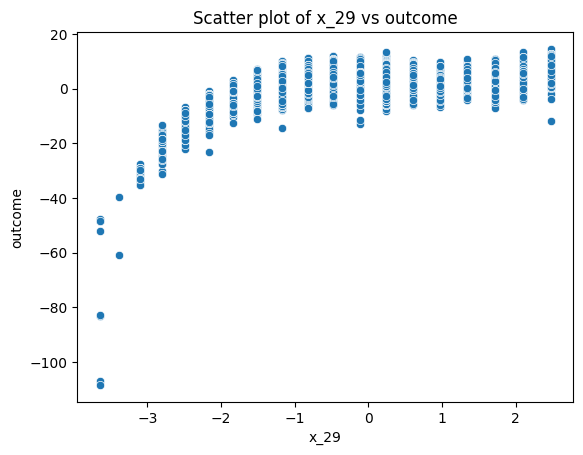

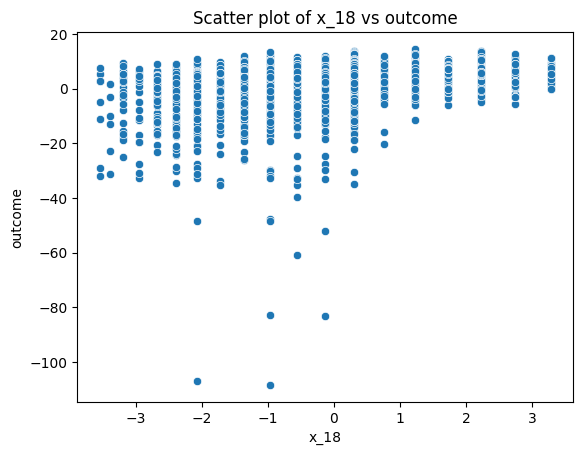

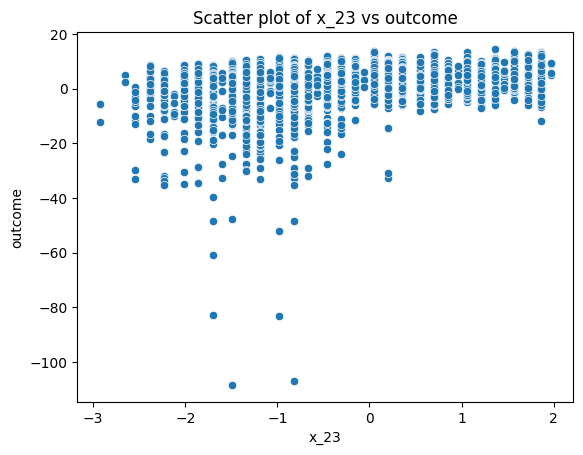

In [13]:
# For the following columns 'x_29', 'x_18', and 'x_23', create a scatter plot with the outcome variable
for col in ['x_29', 'x_18', 'x_23']:
    sns.scatterplot(data=df, x=col, y='outcome')
    plt.title(f'Scatter plot of {col} vs outcome')
    plt.show()

Essentially, we have a weak correlation between the two other covariates 'x_18' and 'x_23'. We may be able to use them for the nonlinear biasing function. 